# Imports

In [19]:
from datasets import load_dataset
import numpy as np
from datasets import Dataset
import matplotlib.pyplot as plt
from transformers import AutoTokenizer,Trainer, TrainingArguments,AutoModelForSequenceClassification
import torch
from sklearn.metrics import accuracy_score, f1_score,ConfusionMatrixDisplay, confusion_matrix

### Loading the dataset from HuggingFace Hub

In [4]:
spoilers = load_dataset("bhavyagiri/imdb-spoiler")

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/datasets/packaged_modules/csv/csv.py:154: FutureWarning: the 'mangle_dupe_cols' keyword is deprecated and will be removed in a future version. Please take steps to stop the use of 'mangle_dupe_cols'
  csv_file_reader = pd.read_csv(file, iterator=True, dtype=dtype, **self.config.read_csv_kwargs)


Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/bhavyagiri--imdb-spoiler-fea50a4103b1b489/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


/opt/conda/lib/python3.10/site-packages/datasets/packaged_modules/csv/csv.py:154: FutureWarning: the 'mangle_dupe_cols' keyword is deprecated and will be removed in a future version. Please take steps to stop the use of 'mangle_dupe_cols'
  csv_file_reader = pd.read_csv(file, iterator=True, dtype=dtype, **self.config.read_csv_kwargs)


  0%|          | 0/2 [00:00<?, ?it/s]

In [5]:
train_ds = spoilers["train"]
train_ds

Dataset({
    features: ['Unnamed: 0', 'text', 'label'],
    num_rows: 22956
})

### Loading the Base-Model

In [6]:
model_ckpt = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

### Tokenizing the dataset

In [7]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

In [8]:
spoilers_encoded = spoilers.map(tokenize, batched=True, batch_size=1024)

  0%|          | 0/23 [00:00<?, ?ba/s]

  0%|          | 0/6 [00:00<?, ?ba/s]

In [9]:
spoilers_encoded

DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0', 'text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 22956
    })
    validation: Dataset({
        features: ['Unnamed: 0', 'text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 5740
    })
})

### Using the model for classificating and putting it on GPU

In [10]:
device = torch.device("cuda")
num_labels = 2
model = (AutoModelForSequenceClassification
         .from_pretrained(model_ckpt, num_labels=num_labels)
         .to(device))

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.weight', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Evaluation metrics

In [11]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

In [12]:
from huggingface_hub import notebook_login

notebook_login()

### Fine-Tuning

In [14]:
batch_size = 16
logging_steps = len(spoilers_encoded["train"]) // batch_size
model_name = f"{model_ckpt}-finetuned-imdb-spoilers"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=3,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=True,
                                  log_level="error")

In [15]:
trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=spoilers_encoded["train"],
                  eval_dataset=spoilers_encoded["validation"],
                  tokenizer=tokenizer)
trainer.train();

Cloning https://huggingface.co/bhavyagiri/roberta-base-finetuned-imdb-spoilers into local empty directory.


Download file pytorch_model.bin:   0%|          | 1.40k/476M [00:00<?, ?B/s]

Download file runs/Aug19_02-18-51_39eb4082d68f/events.out.tfevents.1692411712.39eb4082d68f.28.0: 100%|########…

Download file runs/Aug19_00-14-32_5edc0c1554c6/events.out.tfevents.1692404263.5edc0c1554c6.28.0: 100%|########…

Download file runs/Aug18_11-06-44_cbb635d6ae47/events.out.tfevents.1692356816.cbb635d6ae47.28.1: 100%|########…

Download file runs/Aug18_11-07-19_cbb635d6ae47/events.out.tfevents.1692356843.cbb635d6ae47.28.2: 100%|########…

Download file training_args.bin: 100%|##########| 3.93k/3.93k [00:00<?, ?B/s]

Download file runs/Aug18_11-02-35_cbb635d6ae47/events.out.tfevents.1692356567.cbb635d6ae47.28.0: 100%|########…

Clean file runs/Aug19_02-18-51_39eb4082d68f/events.out.tfevents.1692411712.39eb4082d68f.28.0:  22%|##2       |…

Clean file runs/Aug19_00-14-32_5edc0c1554c6/events.out.tfevents.1692404263.5edc0c1554c6.28.0:  25%|##4       |…

Clean file runs/Aug18_11-06-44_cbb635d6ae47/events.out.tfevents.1692356816.cbb635d6ae47.28.1:  25%|##4       |…

Clean file runs/Aug18_11-07-19_cbb635d6ae47/events.out.tfevents.1692356843.cbb635d6ae47.28.2:  22%|##2       |…

Clean file training_args.bin:  25%|##5       | 1.00k/3.93k [00:00<?, ?B/s]

Clean file runs/Aug18_11-02-35_cbb635d6ae47/events.out.tfevents.1692356567.cbb635d6ae47.28.0:  25%|##4       |…

Clean file pytorch_model.bin:   0%|          | 1.00k/476M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.487400,0.465951,0.790070,0.758326
2,0.425800,0.483205,0.790418,0.764955
3,0.347300,0.524045,0.783275,0.773021


Several commits (2) will be pushed upstream.
Several commits (3) will be pushed upstream.
Several commits (4) will be pushed upstream.
Several commits (5) will be pushed upstream.
Several commits (6) will be pushed upstream.
Several commits (7) will be pushed upstream.
Several commits (8) will be pushed upstream.


[Weights & Baises Report](https://wandb.ai/bhavyagiri/huggingface/reports/IMDB-Roberta--Vmlldzo1MTg1Mjk1)

### Validation metrics

In [16]:
preds_output = trainer.predict(spoilers_encoded["validation"])
y_preds = np.argmax(preds_output.predictions, axis=1)

In [17]:
preds_output.metrics

{'test_loss': 0.5240445733070374,
 'test_accuracy': 0.7832752613240418,
 'test_f1': 0.7730205935926013,
 'test_runtime': 107.1021,
 'test_samples_per_second': 53.594,
 'test_steps_per_second': 3.352}

### Confusion matrix on validation set

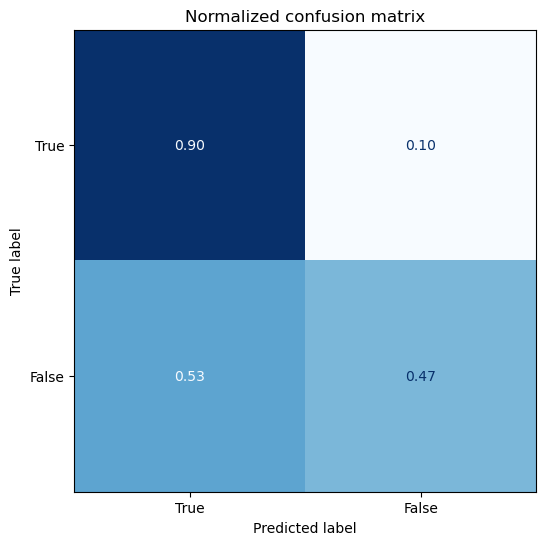

In [20]:
labels = [True,False]
y_valid = spoilers_encoded["validation"]["label"]
def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()
plot_confusion_matrix(y_preds, y_valid, labels)